In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from tensorflow.keras.applications import VGG19


from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

train_dir= "/content/drive/MyDrive/Yoga Dataset 1/TRAIN"

val_dir = "/content/drive/MyDrive/Yoga Dataset 1/TEST"

In [6]:
labels = []
train_counts = []
for dirname in os.listdir(train_dir):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join(train_dir,dirname)):
        image_count +=1
    train_counts.append(image_count)

In [7]:
print(labels)
print(train_counts)

['goddess', 'downdog', 'tree', 'plank', 'warrior2']
[180, 223, 165, 266, 252]


In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1. / 255)

In [9]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=16,
                                            class_mode='categorical',
                                            target_size=(150, 150),
                                                    shuffle=True)


valid_generator = valid_datagen.flow_from_directory(val_dir,
                                                    batch_size=16,
                                            class_mode='categorical',
                                                target_size=(150, 150),
                                                    shuffle=False)

Found 1086 images belonging to 5 classes.
Found 484 images belonging to 5 classes.


In [10]:
class_weights = []
total_samples = train_generator.samples
total_classes = len(train_generator.class_indices)
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))
print(class_weights)

{0: 1.21, 1: 0.97, 2: 1.32, 3: 0.82, 4: 0.86}


In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)# used to initialize random number generator

In [12]:
def custom_model():
    
    
    cus_model = VGG19(input_shape = (150,150,3),        
                         weights='imagenet', 
                         include_top= False,)# Lets us to select if we want the last dense layer or not
    
   #Using pre-trained weights from imagenet 
    for layer in cus_model.layers:
        layer.trainable = False# The Freezing of the layer

    # Adding layers in a sequential manner
    x = layers.Flatten()(cus_model.output)

    x = layers.Dense(512, activation='relu')(x)
    
    x = layers.Dropout(0.2)(x)
 
    x = layers.Dense(5, activation='softmax')(x)

    model = Model(cus_model.input,x)
    
    return model

In [13]:
model = custom_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Checkpoint callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint("yoga_model.h5", save_best_only=True)

# Early stopping callback
early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [17]:
history = model.fit(train_generator,
                    validation_data=valid_generator,
                    epochs=30,
                    batch_size=32,
                    callbacks=[lr_scheduler_ed, early_stopping_m],
                    verbose=1
                    )

Epoch 1/30
25/68 [==========>...................] - ETA: 2:59 - loss: 1.4180 - accuracy: 0.5150

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


68/68 [==============================] - ETA: 0s - loss: 0.9725 - accuracy: 0.6703

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


68/68 [==============================] - 409s 6s/step - loss: 0.9725 - accuracy: 0.6703 - val_loss: 0.2144 - val_accuracy: 0.9339 - lr: 9.0000e-04
Epoch 2/30
68/68 [==============================] - 409s 6s/step - loss: 0.4337 - accuracy: 0.8600 - val_loss: 0.1812 - val_accuracy: 0.9483 - lr: 5.6786e-04
Epoch 3/30
68/68 [==============================] - 409s 6s/step - loss: 0.2955 - accuracy: 0.9098 - val_loss: 0.1383 - val_accuracy: 0.9587 - lr: 3.5830e-04
Epoch 4/30
68/68 [==============================] - 409s 6s/step - loss: 0.2309 - accuracy: 0.9365 - val_loss: 0.1388 - val_accuracy: 0.9628 - lr: 2.2607e-04
Epoch 5/30
68/68 [==============================] - 409s 6s/step - loss: 0.1981 - accuracy: 0.9448 - val_loss: 0.1263 - val_accuracy: 0.9669 - lr: 1.4264e-04
Epoch 6/30
68/68 [==============================] - 407s 6s/step - loss: 0.1788 - accuracy: 0.9503 - val_loss: 0.1311 - val_accuracy: 0.9628 - lr: 9.0000e-05
Epoch 7/30
68/68 [==============================] - 409s 6s/ste

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(valid_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

 4/68 [>.............................] - ETA: 4:24 - loss: 0.1011 - accuracy: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


14/31 [============>.................] - ETA: 1:11 - loss: 0.1691 - accuracy: 0.9420

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


31/31 [==============================] - 127s 4s/step - loss: 0.1259 - accuracy: 0.9628
final train accuracy = 97.79 , validation accuracy = 96.28


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 11 bytes but only got 10. Skipping tag 42037
  " Skipping tag %s" % (size, len(data), tag)


              precision    recall  f1-score   support

     downdog       0.99      0.93      0.96        97
     goddess       0.99      0.93      0.96        82
       plank       0.95      0.99      0.97       115
        tree       0.97      0.97      0.97        78
    warrior2       0.93      0.98      0.96       112

    accuracy                           0.96       484
   macro avg       0.97      0.96      0.96       484
weighted avg       0.96      0.96      0.96       484



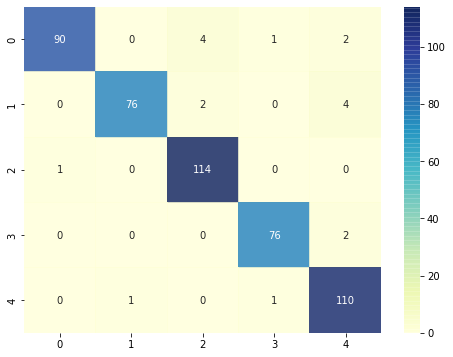

In [21]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
predictions = model.predict_generator(valid_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())   
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(confusion_matrix(true_classes, predicted_classes)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)